
# Libraries

In [120]:
import itertools

from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

import os
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt


# Creating dataset

In [121]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image transformations

In [122]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [123]:
train_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/normal',
    'viral': 'COVID-19_Radiography_Dataset/viral',
    'covid': 'COVID-19_Radiography_Dataset/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 9992 normal examples
Found 1145 viral examples
Found 3416 covid examples


In [124]:
test_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/test/normal',
    'viral': 'COVID-19_Radiography_Dataset/test/viral',
    'covid': 'COVID-19_Radiography_Dataset/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 200 normal examples
Found 200 viral examples
Found 200 covid examples


In [125]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2426
Number of test batches 100


# Data visualization

In [126]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

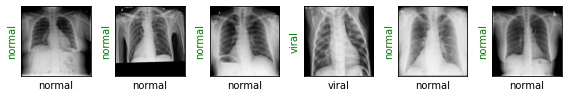

In [127]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

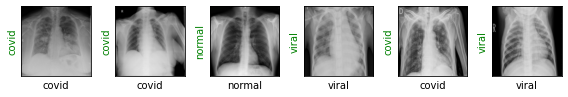

In [128]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the model

In [129]:
model = torchvision.models.resnet18(pretrained=True)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [130]:
model.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [131]:
def show_preds():
    model.eval()
    images, labels = next(iter(dl_test))
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

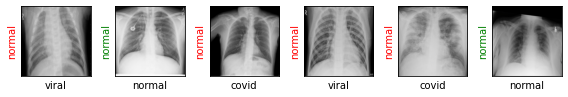

In [132]:
show_preds()

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Training the model

In [133]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        model.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                model.eval() # set model to eval phase
                pred_list = []
                true_list = []
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())
                    pred_list += list(preds.numpy())
                    true_list += list(labels.numpy())


                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(classification_report(pred_list, true_list))
                cm =  confusion_matrix(true_list, pred_list)
                plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = ['normal', 'viral', 'covid'],
                      title        = "Confusion Matrix")
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                model.train()

                if accuracy >= 0.99:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/3
Evaluating at step 0
              precision    recall  f1-score   support

           0       0.98      0.34      0.50       566
           1       0.05      0.50      0.09        20
           2       0.06      0.86      0.11        14

    accuracy                           0.36       600
   macro avg       0.36      0.56      0.23       600
weighted avg       0.93      0.35      0.48       600



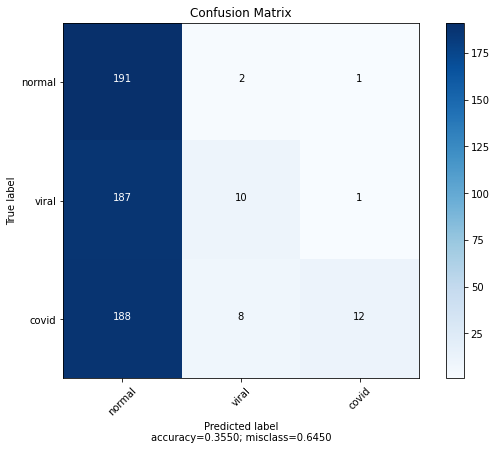

Validation Loss: 1.1137, Accuracy: 0.3550


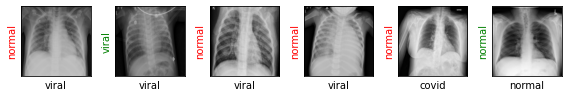

Evaluating at step 20
              precision    recall  f1-score   support

           0       0.99      0.47      0.63       451
           1       0.66      0.99      0.79       137
           2       0.05      0.75      0.09        12

    accuracy                           0.59       600
   macro avg       0.57      0.74      0.51       600
weighted avg       0.89      0.59      0.66       600



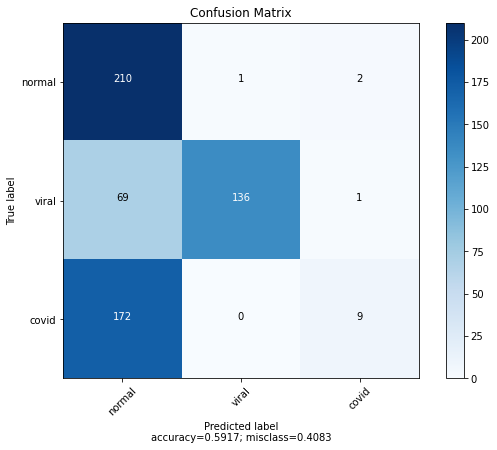

Validation Loss: 0.7817, Accuracy: 0.5917


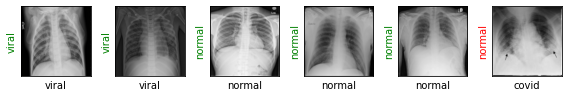

In [ ]:
%%time

train(epochs=3)

# Results

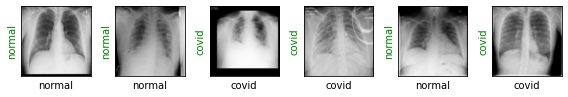

In [44]:
show_preds()


In [ ]:
traced_model = torch.jit.script(model, images)
torch.jit.save(traced_model, "modelV1.pt")
